In [1]:
import json
import numpy as np
import os

# Function to load KL configuration
def load_kl_config(config_file):
    with open(config_file, 'r') as file:
        kl_config = json.load(file)
    return kl_config

# Function to load the appropriate .npy file
def load_npy_file(model_name, revision):
    # Replace '/' with '_' in model name
    model_name_sanitized = model_name.replace('/', '-')
    
    # Construct the filename
    filename = f"{model_name_sanitized}_{revision}_kl.npy"
    
    # Construct the full path to the file
    filepath = os.path.join("results", filename)
    
    # Load the .npy file
    if os.path.exists(filepath):
        data = np.load(filepath)
        return data
    else:
        raise FileNotFoundError(f"The file {filename} does not exist in the 'results' folder.")

# Function to find the index of the model_name and revision combination in the KL data
def find_comparison_index(kl_config, model_name, revision, target_model_name, target_revision):
    model_names = kl_config['model_names']
    revisions = kl_config['revisions']
    
    # Get the index of the model_name and revision
    model_index = model_names.index(model_name)
    revision_index = revisions.index(revision)
    
    target_model_index = model_names.index(target_model_name)
    target_revision_index = revisions.index(target_revision)
    
    # Calculate the comparison index based on the nested loop
    comparison_index = (
        target_model_index * len(revisions) + target_revision_index
    ) - (model_index * len(revisions) + revision_index) - 1
    
    if comparison_index < 0:
        raise ValueError(f"No valid comparison between {model_name} and {target_model_name} with revisions {revision} and {target_revision} respectively.")
    
    return comparison_index

# Function to retrieve the (1, 4171) slice from the data
def get_comparison_data(kl_config, data, model_name, revision, target_model_name, target_revision):
    # Find the comparison index
    comparison_index = find_comparison_index(kl_config, model_name, revision, target_model_name, target_revision)
    
    # Return the corresponding (1, 4171) data slice
    return data[comparison_index, :]

In [2]:
kl_config = load_kl_config("kl_config.json")
    
base_model_name = "EleutherAI/pythia-1b-deduped"
base_revision = "step128000"
target_name = "EleutherAI/pythia-1b-deduped"
target_revision = "step143000"

data = get_comparison_data(kl_config, load_npy_file(base_model_name, base_revision), base_model_name, base_revision, target_name, target_revision)

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the JSON array with tokenized text
def load_tokenized_text(json_file):
    with open(json_file, 'r') as file:
        tokenized_text = json.load(file)
    return tokenized_text

# Plot the scores against the text
def plot_scores_against_text(tokenized_text, comparison_data):
    # Ensure comparison_data has the correct shape
    if comparison_data.shape[0] != len(tokenized_text):
        raise ValueError("The number of scores does not match the number of text entries.")

    # Prepare the data for plotting
    y_labels = tokenized_text[::-1]
    x_scores = comparison_data.flatten()[::-1]

    # Create the plot
    plt.figure(figsize=(12, len(y_labels) / 11))  # Adjust the height based on the number of labels
    plt.barh(np.arange(len(y_labels)), x_scores, color='blue')
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, fontsize=8)
    plt.xlabel("Score")
    plt.ylabel("Text")
    plt.title("Score vs Text")
    plt.tight_layout()
    plt.show()

# Load the tokenized text
tokenized_text = load_tokenized_text("input_text_tokenized.json")

# Plot the scores against the text
plot_scores_against_text(tokenized_text, data)

ValueError: The number of scores does not match the number of text entries.

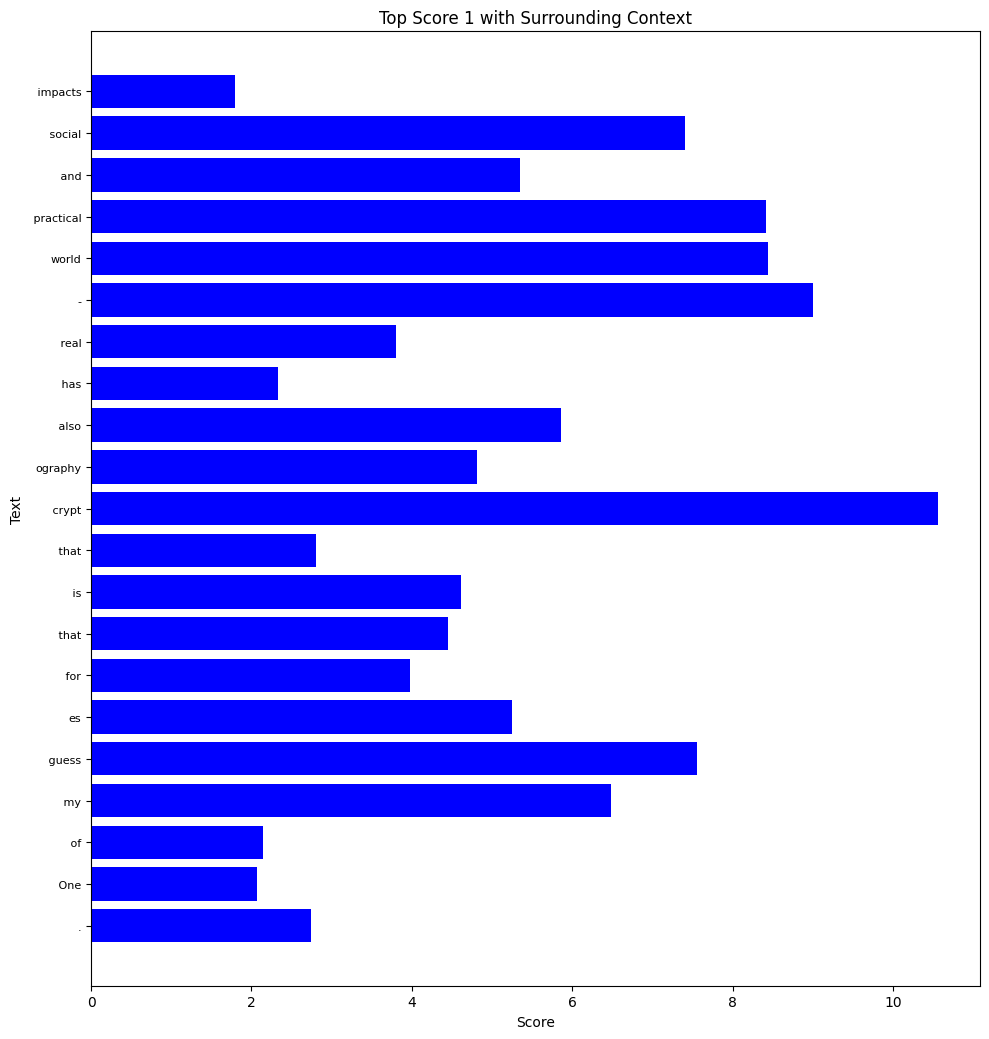

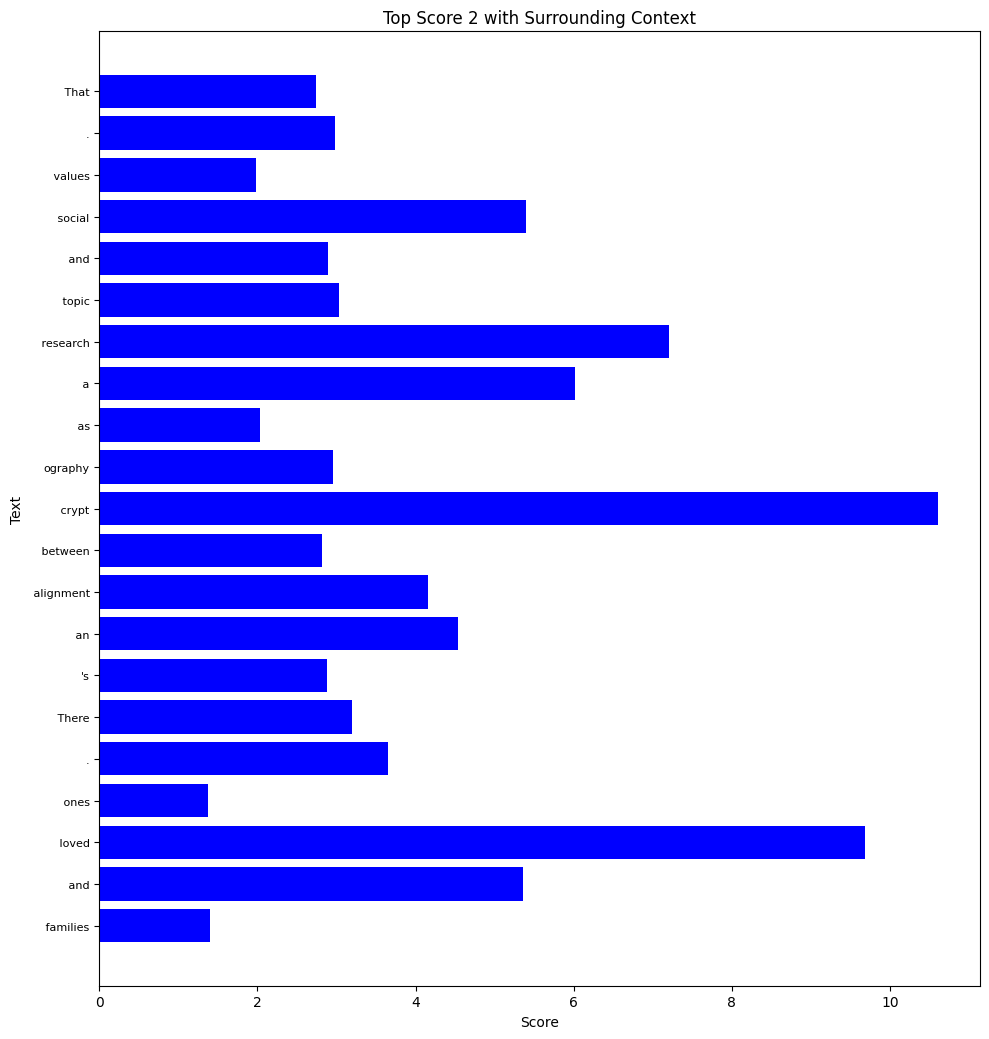

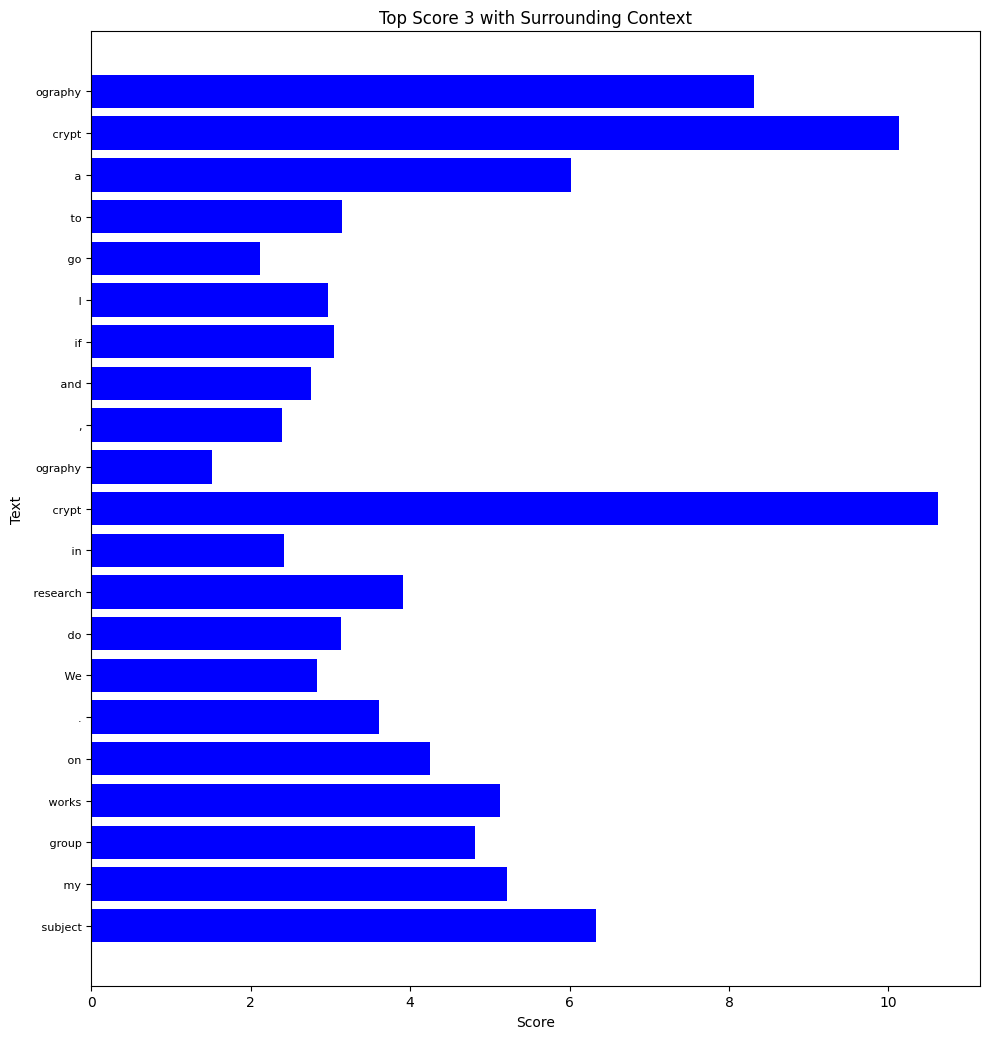

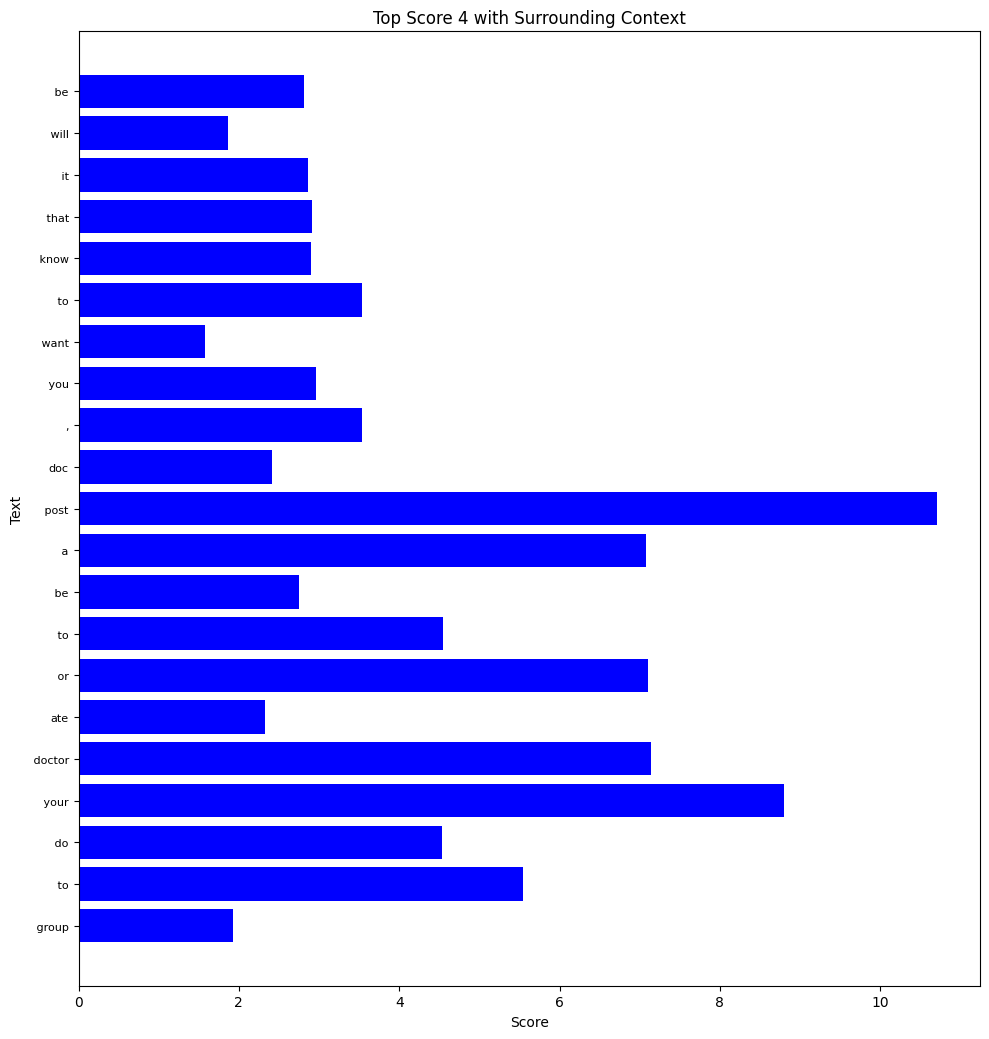

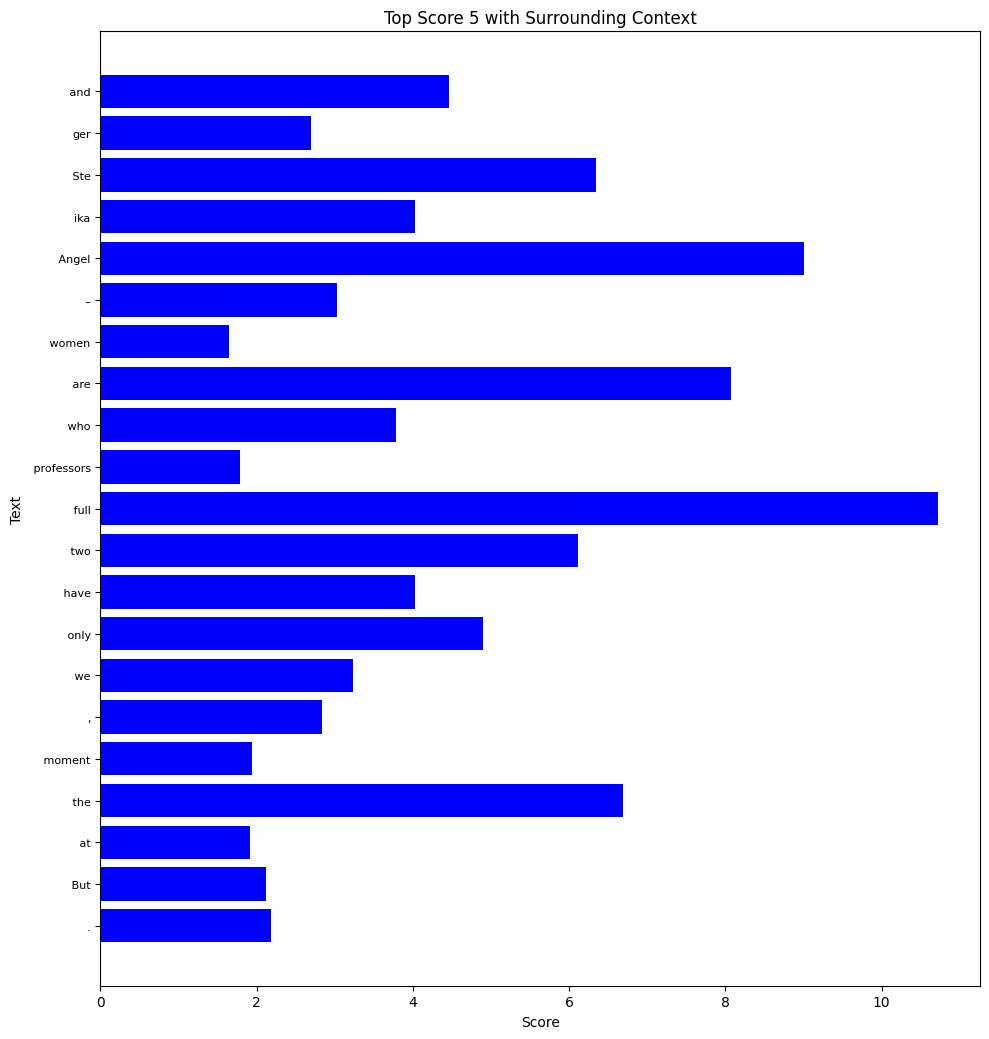

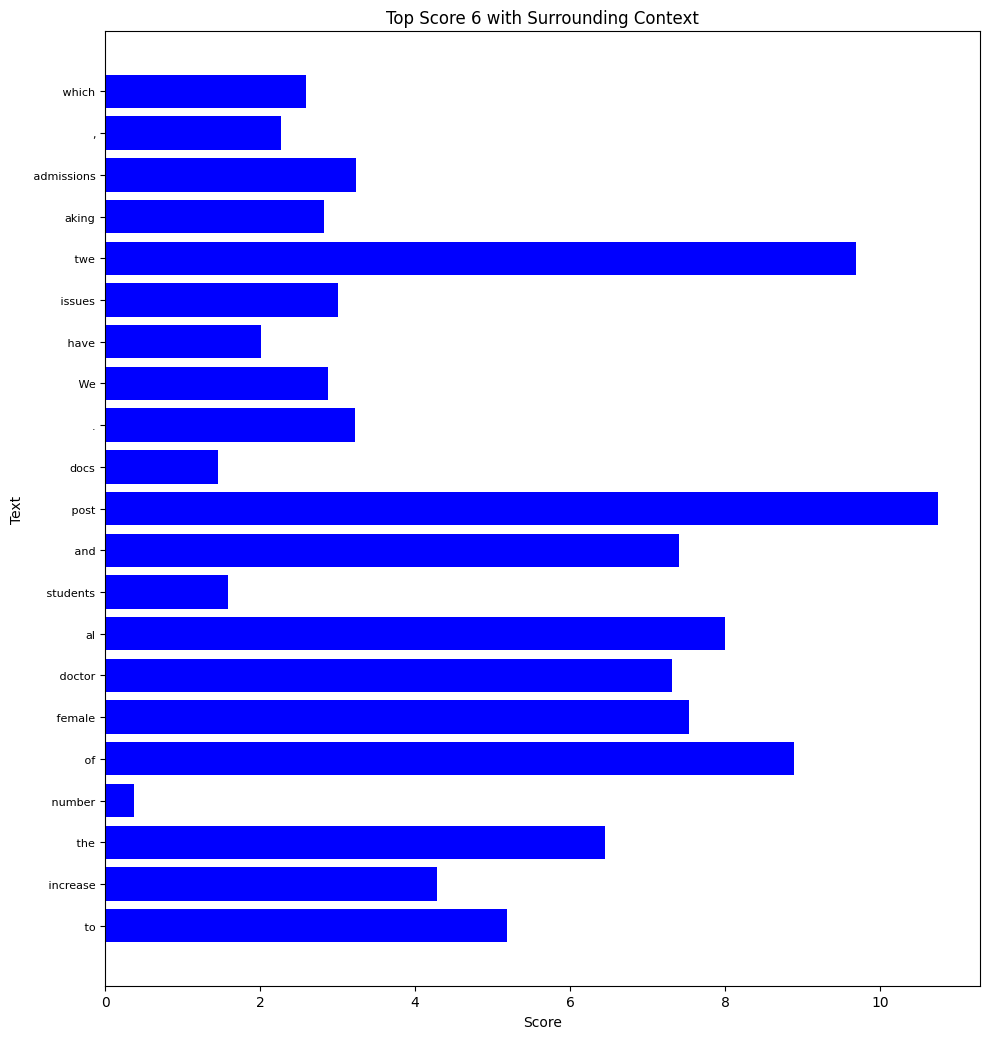

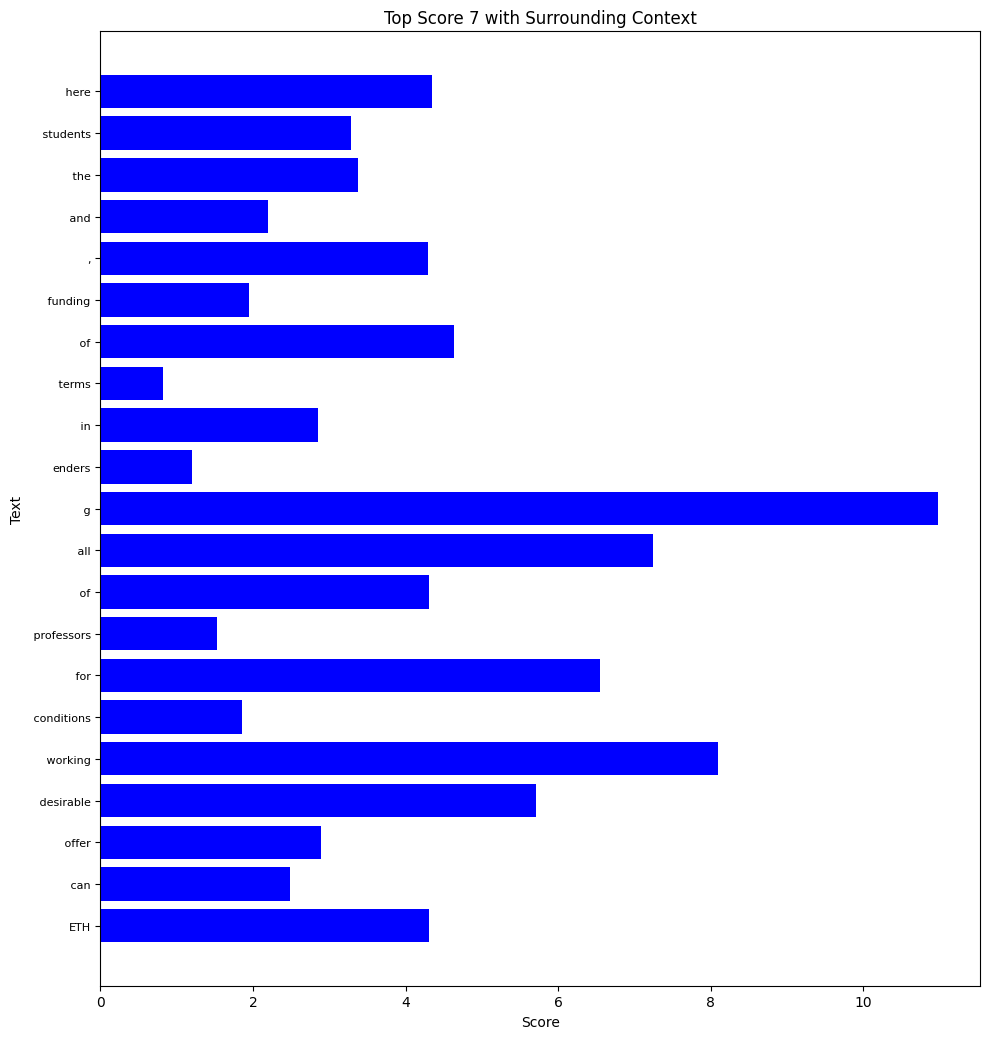

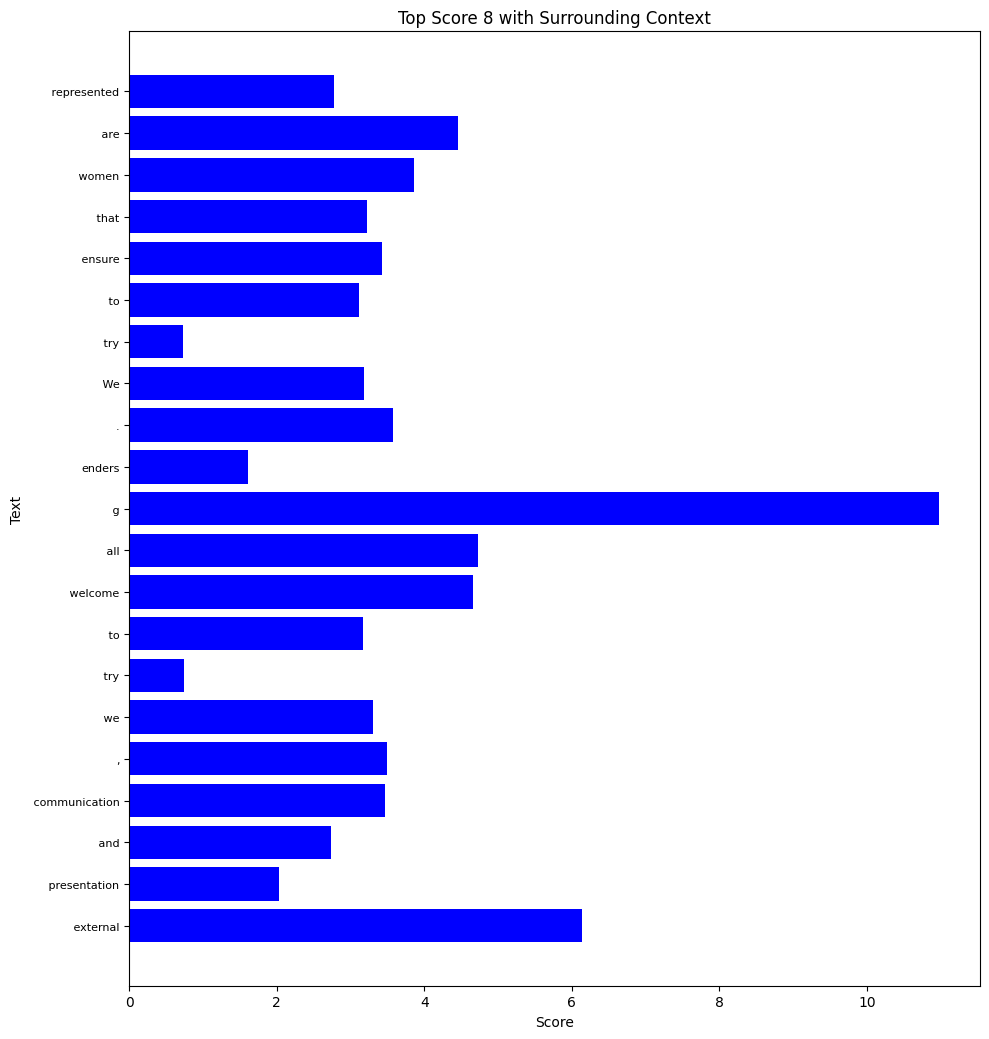

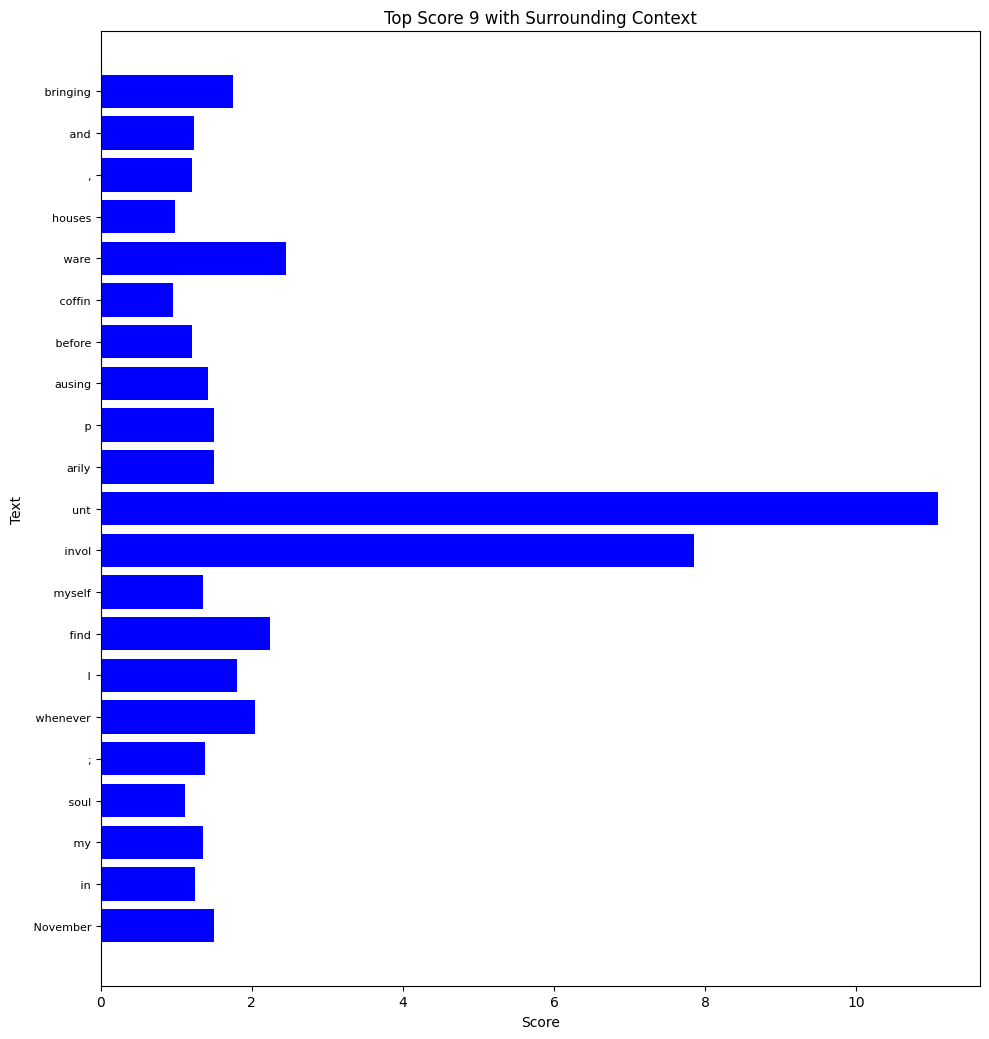

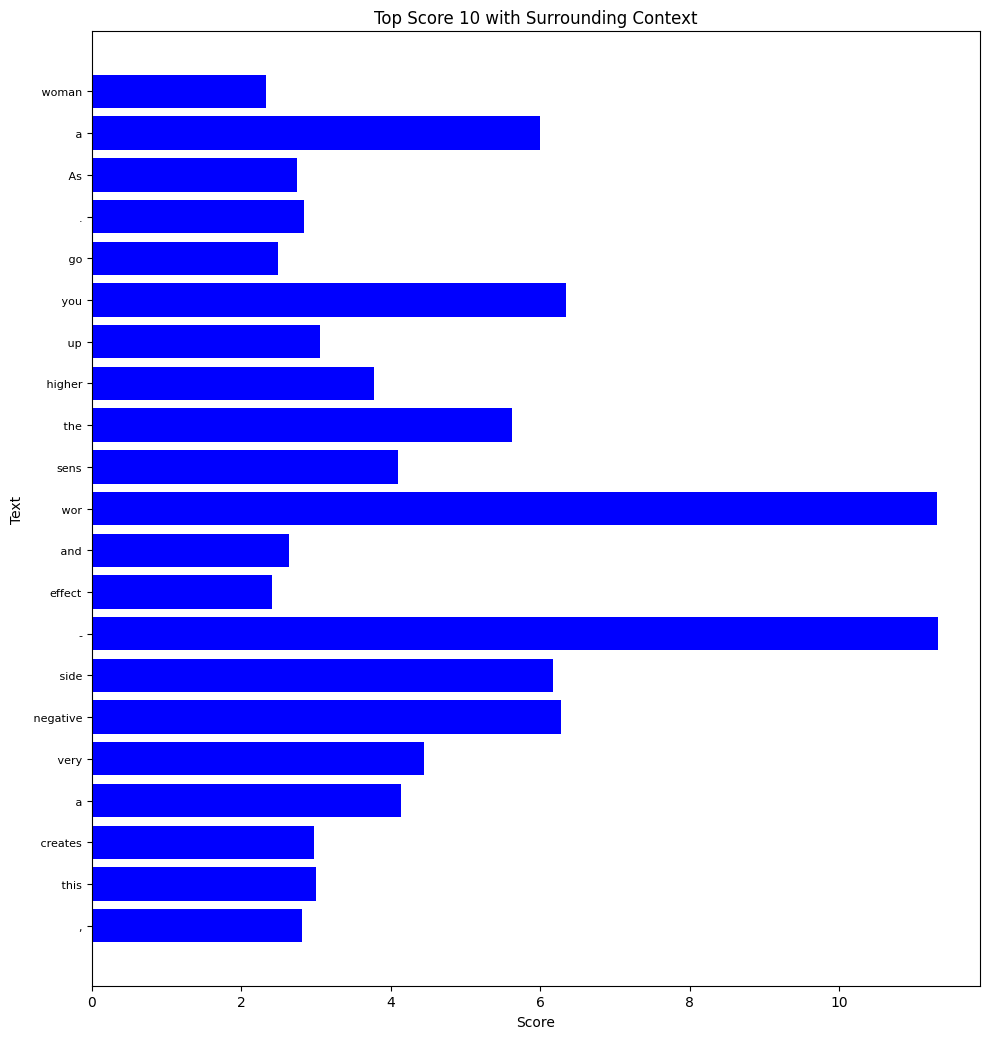

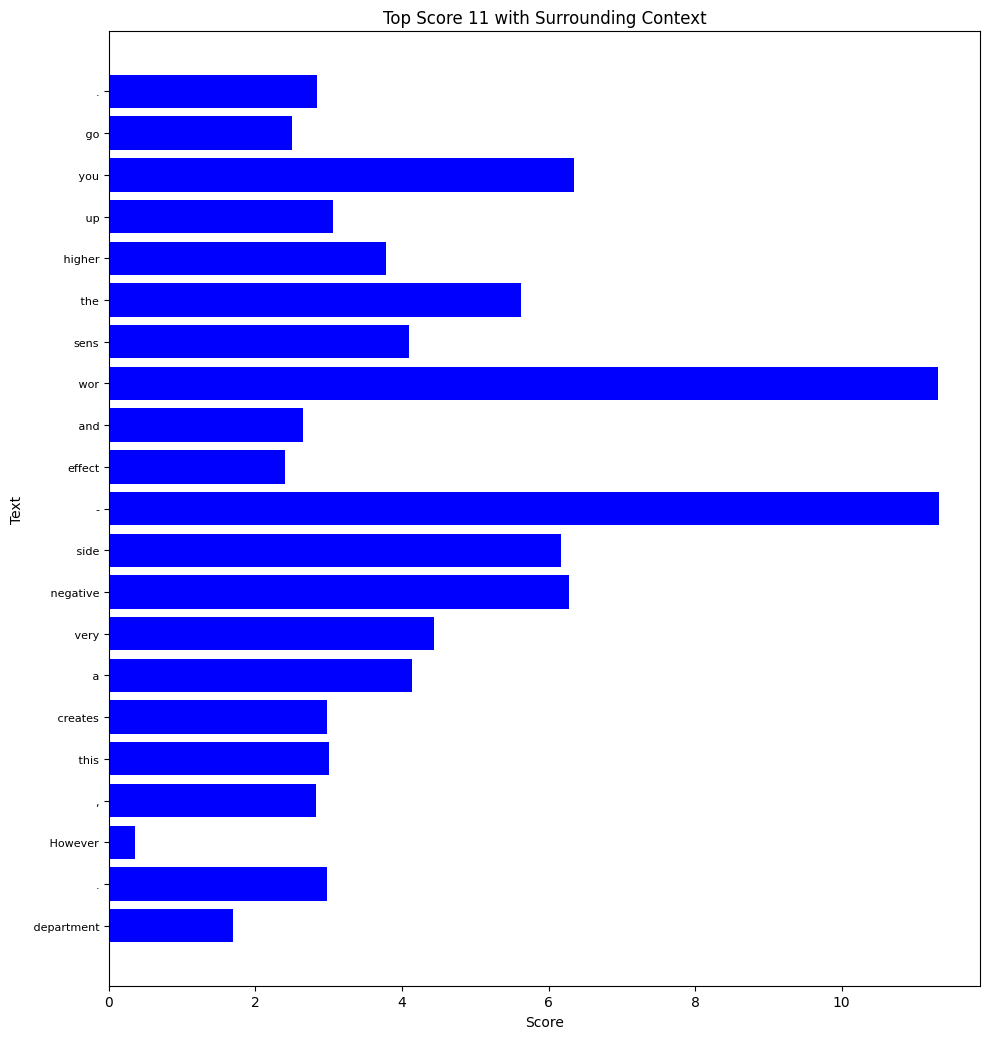

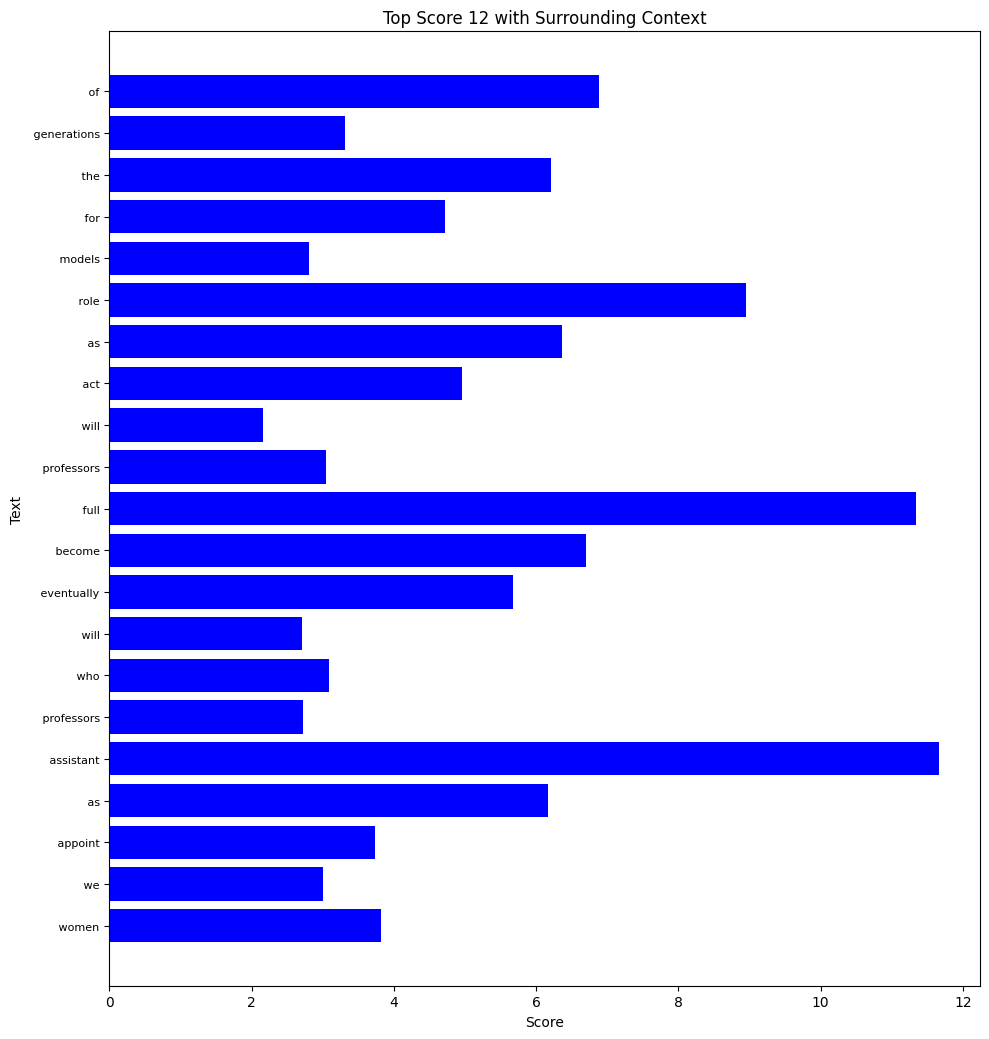

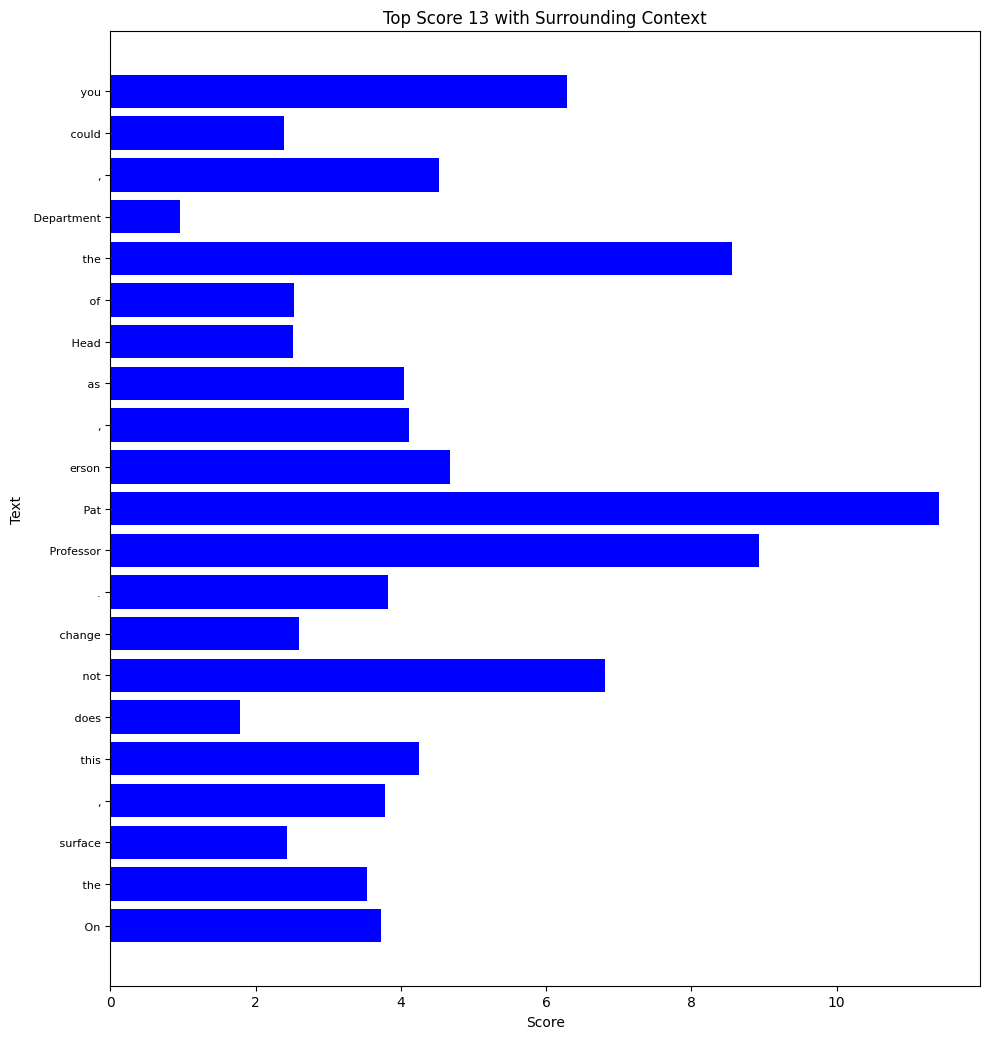

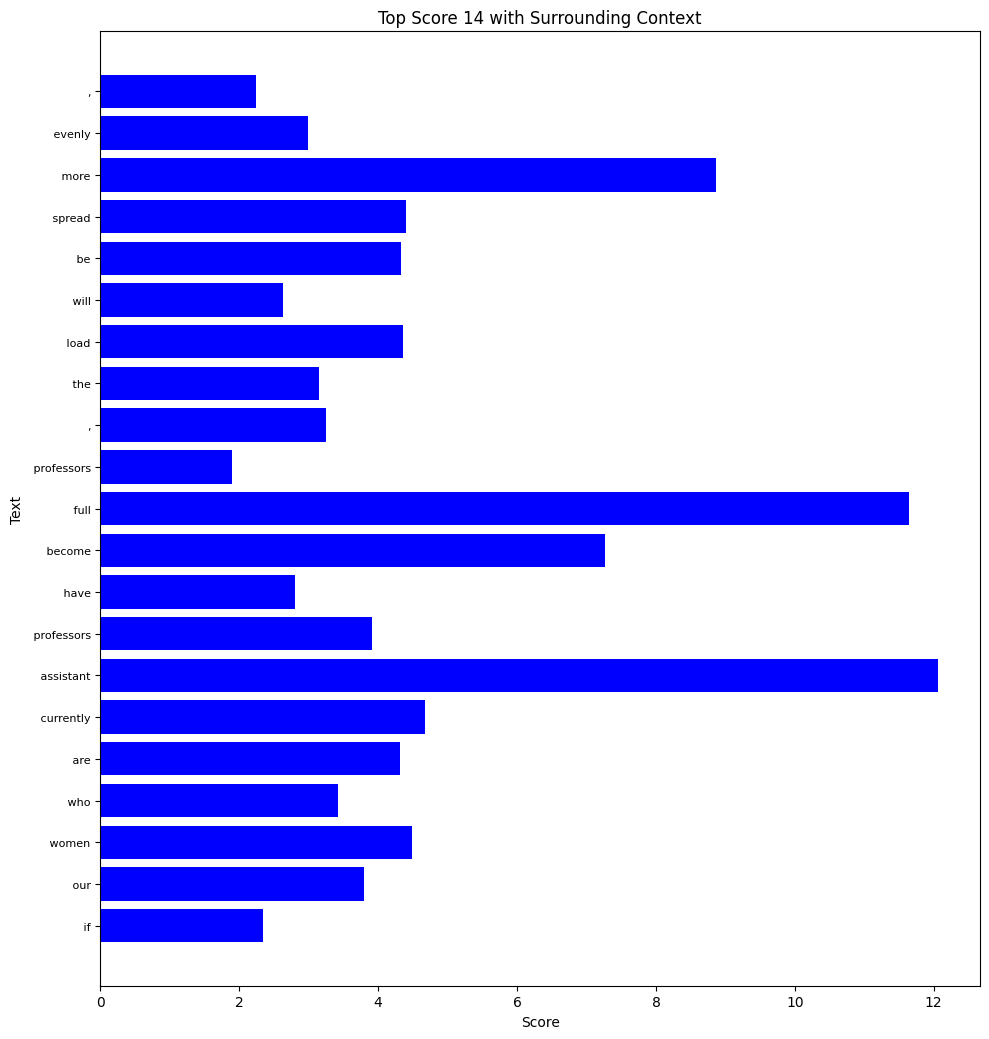

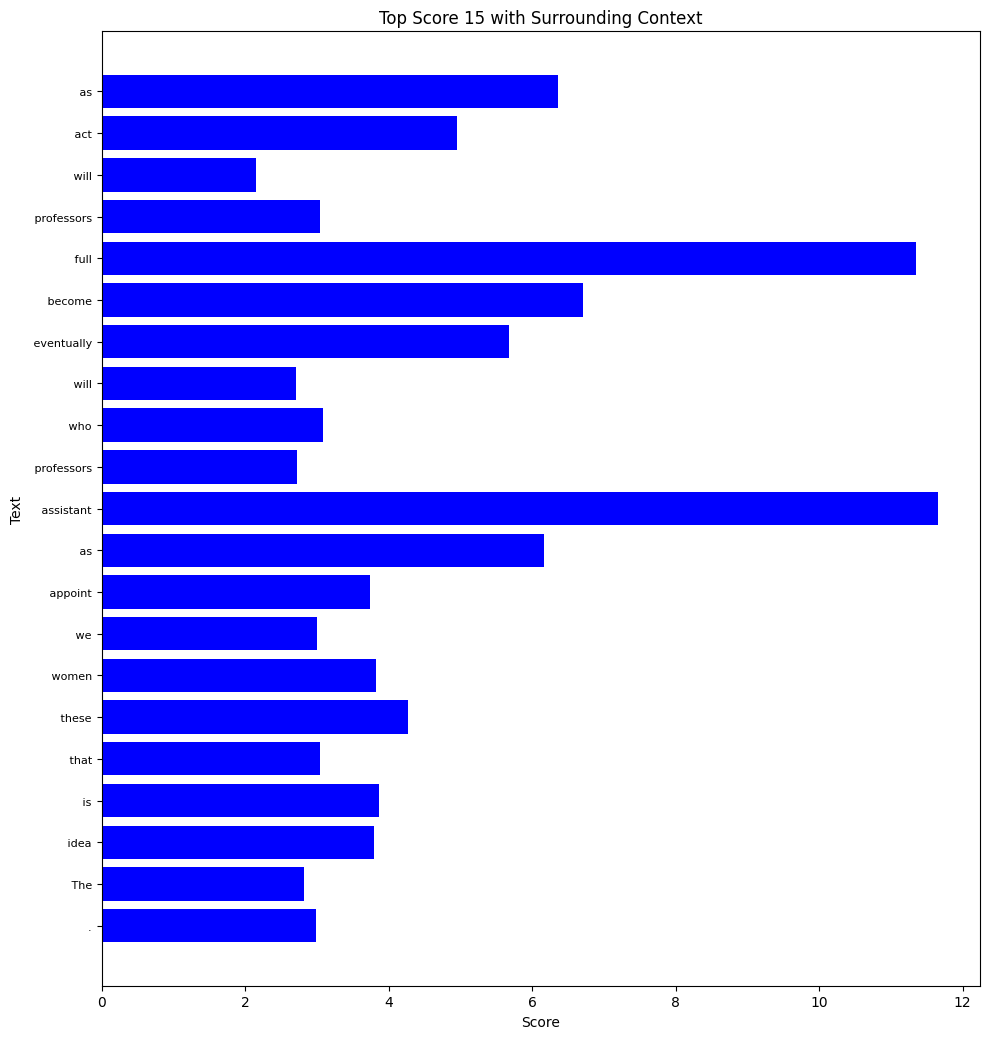

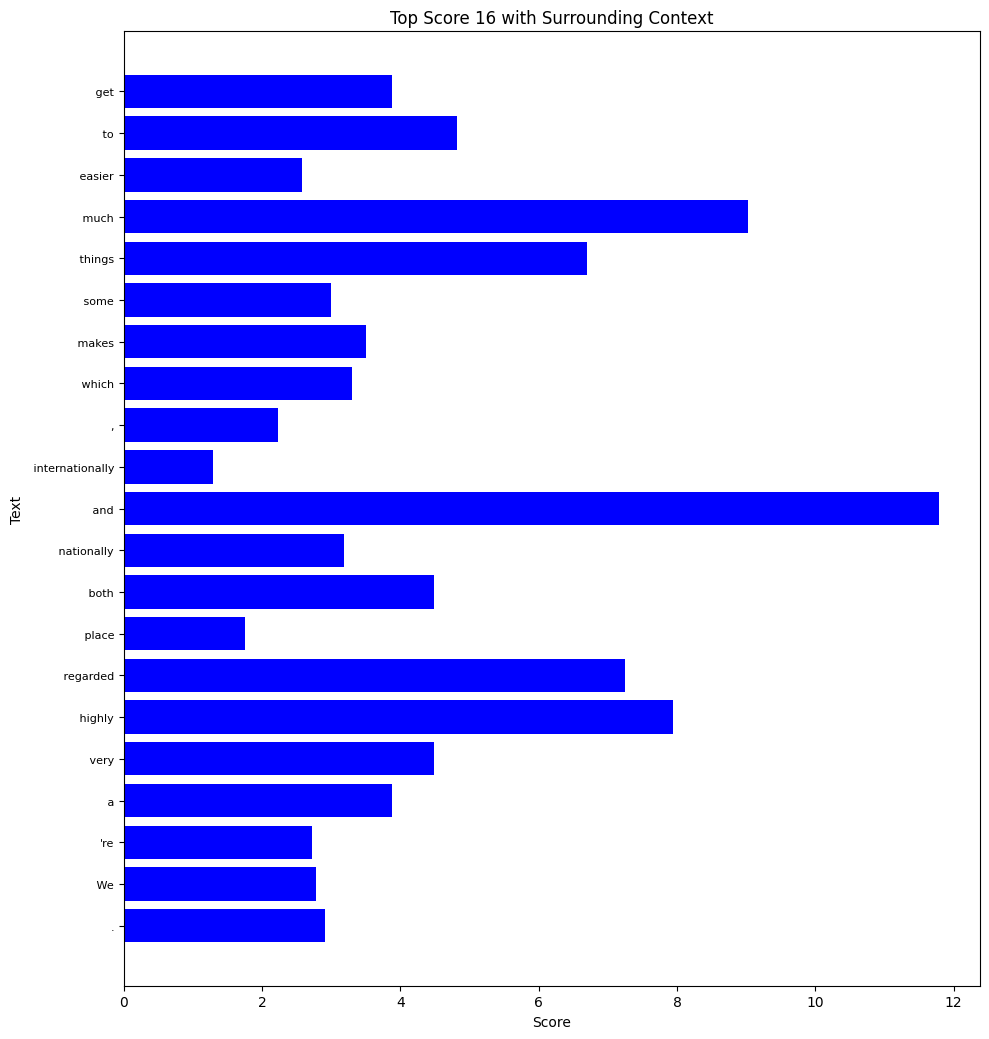

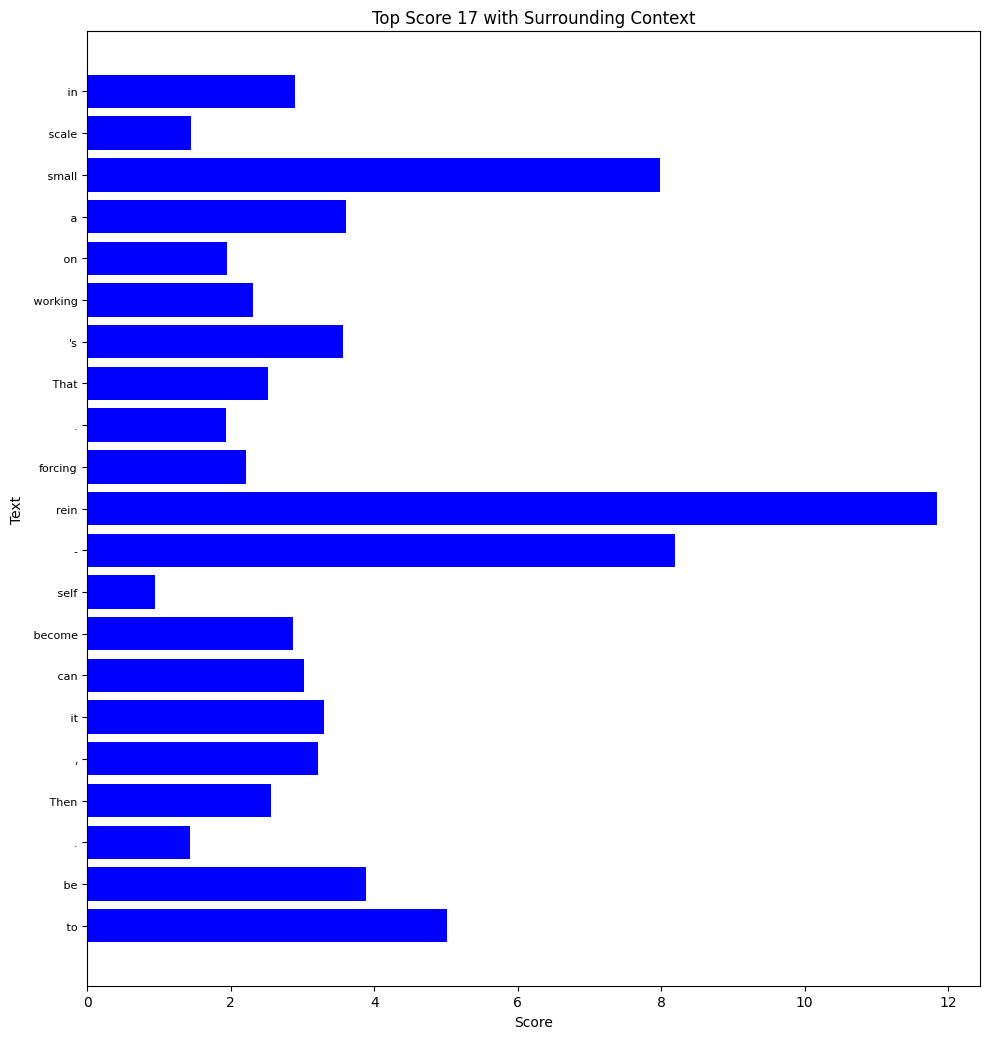

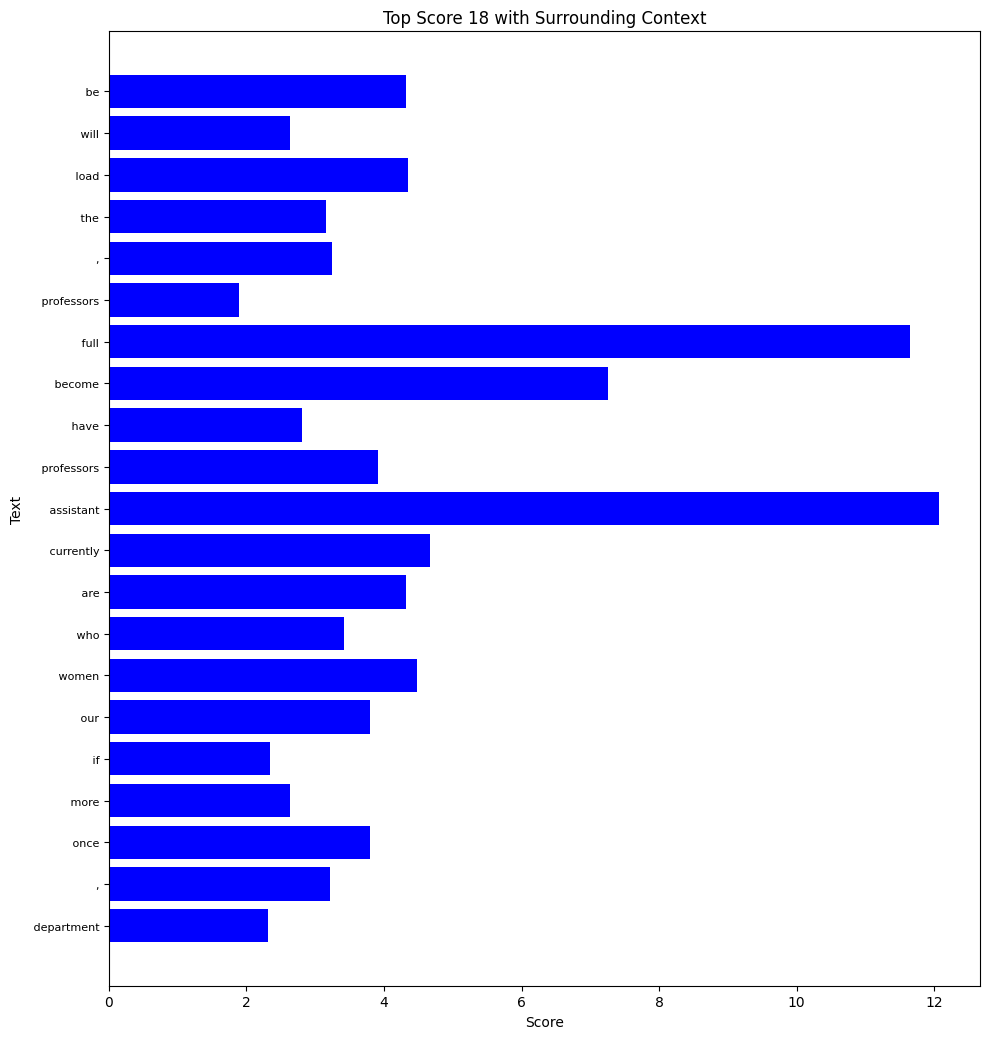

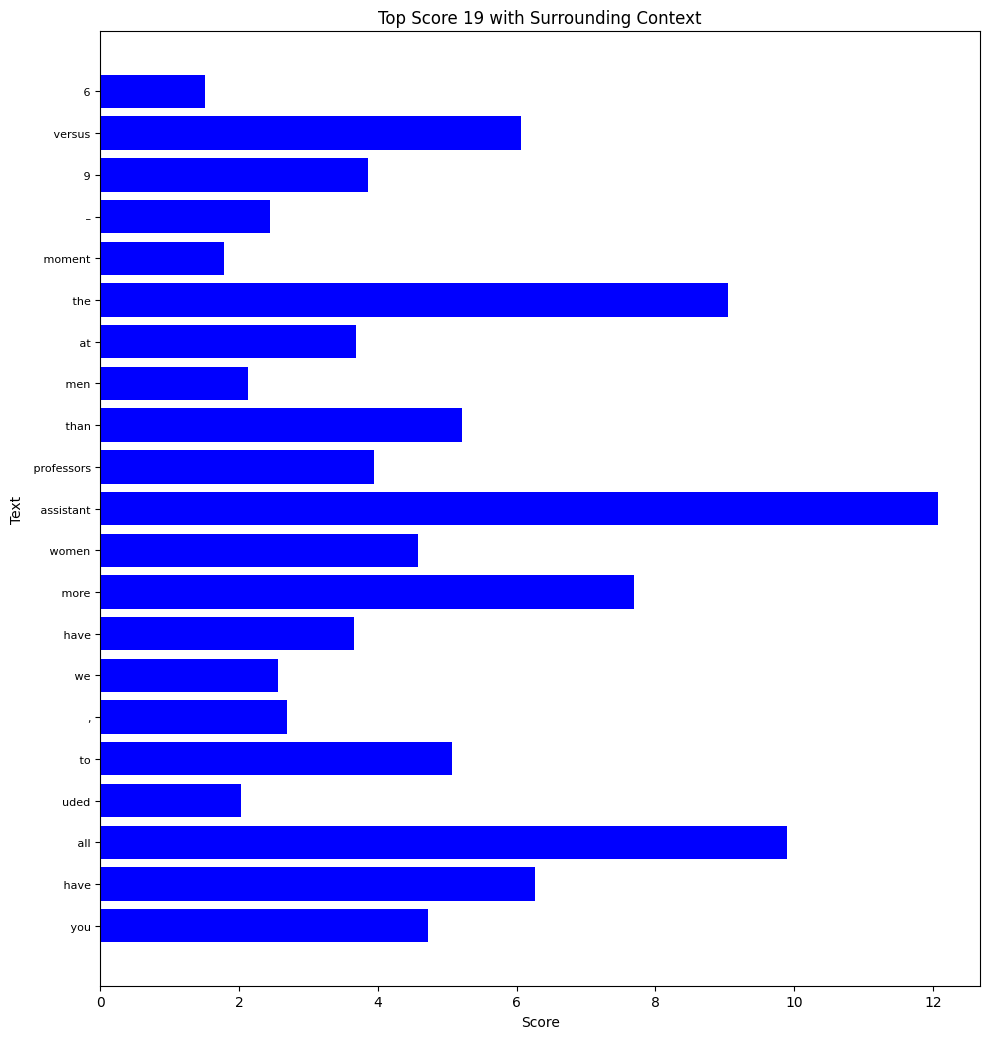

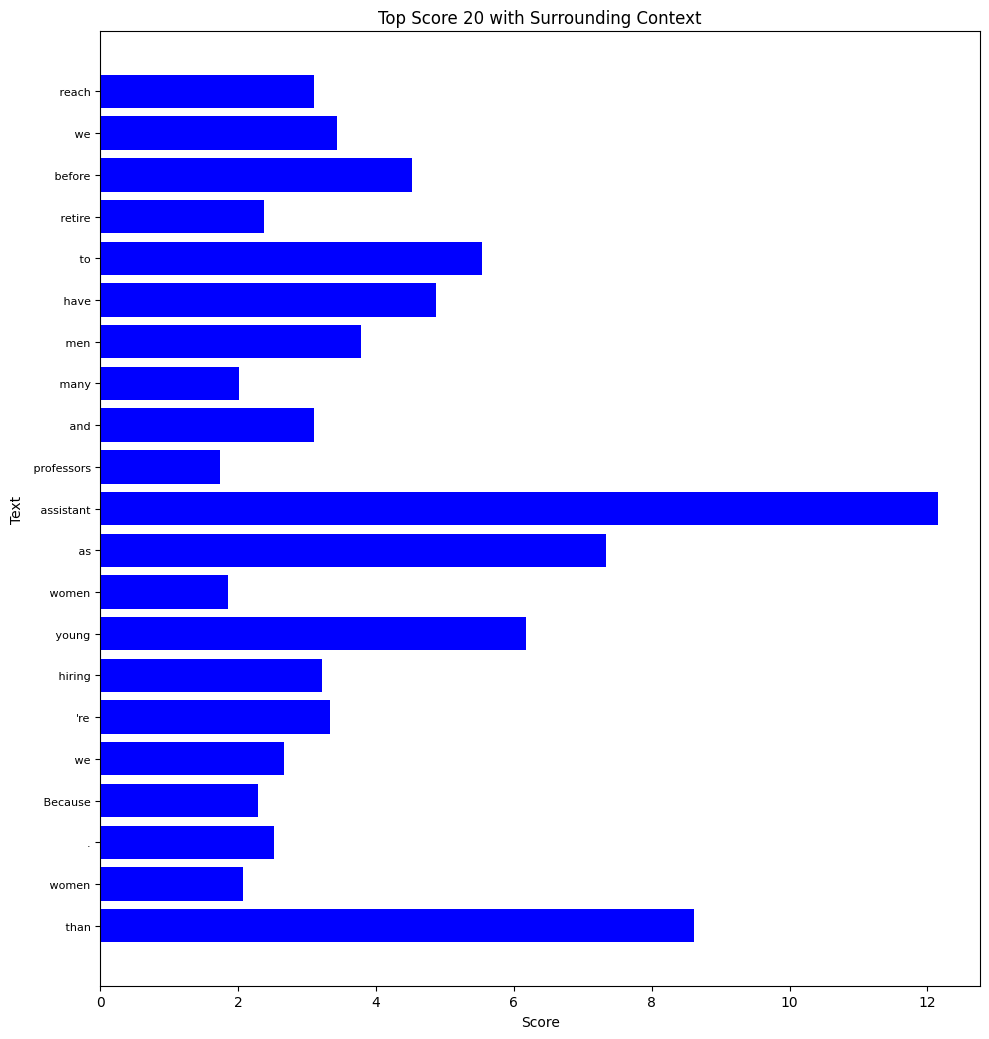

In [25]:
# Find indices of top 20 highest scores and surrounding context
def find_top_scores_with_context(comparison_data, num_top_scores=20, context_size=10):
    flattened_scores = comparison_data.flatten()
    
    # Get indices of top `num_top_scores` highest scores
    top_indices = np.argsort(flattened_scores)[-num_top_scores:]

    # For each top index, collect its surrounding context
    top_scores_contexts = []
    
    for index in top_indices:
        start_index = max(index - context_size, 0)
        end_index = min(index + context_size + 1, len(flattened_scores))
        context_indices = list(range(start_index, end_index))
        top_scores_contexts.append(context_indices)
    
    return top_scores_contexts

# Plot each top score with surrounding context individually
def plot_individual_top_scores(tokenized_text, comparison_data, top_scores_contexts):
    for i, context_indices in enumerate(top_scores_contexts):
        y_labels = [tokenized_text[i] for i in context_indices]
        x_scores = comparison_data.flatten()[context_indices]

        # Create the plot
        plt.figure(figsize=(10, len(y_labels) / 2))  # Adjust the height based on the number of labels
        plt.barh(np.arange(len(y_labels)), x_scores, color='blue')
        plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, fontsize=8)
        plt.xlabel("Score")
        plt.ylabel("Text")
        plt.title(f"Top Score {i+1} with Surrounding Context")
        plt.tight_layout()
        plt.show()

# Plot the top scores with context
context_indices = find_top_scores_with_context(data)
plot_individual_top_scores(tokenized_text, data, context_indices)

In [5]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_scores_with_vertical_lines(tokenized_text, comparison_data, window_size=20):
    # Ensure comparison_data has the correct shape
    if comparison_data.shape[0] != len(tokenized_text):
        print(len(tokenized_text))
        print(comparison_data.shape)
        raise ValueError("The number of scores does not match the number of text entries.")
    
    x_indices = np.arange(len(tokenized_text))
    y_scores = comparison_data.flatten()

    y_moving_avg = moving_average(y_scores, window_size)

    # Create the plot
    plt.figure(figsize=(40, 6))
    plt.plot(x_indices, y_scores, '-o', color='blue')
    
    # Plot the moving average
    plt.plot(x_indices[window_size - 1:], y_moving_avg, color='red', linewidth=2, label='Moving Average')

    # Plot vertical lines where '---' is in the text
    for idx, text in enumerate(tokenized_text):
        if text == '---':
            plt.axvline(x=idx, color='green', linestyle='--')

    plt.xlabel("Index")
    plt.ylabel("Score")
    plt.title("Scores with Vertical Lines for '---' Entries")
    plt.tight_layout()
    plt.show()

plot_scores_with_vertical_lines(tokenized_text, data)

4171
(6144,)


ValueError: The number of scores does not match the number of text entries.

7168


ValueError: could not broadcast input array from shape (0,) into shape (2048,)